## Install Pytorch if needed

In [0]:
# http://pytorch.org/


# from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
# import torch

## Import modules

In [9]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
print("Pytorch version:  " + str(torch.__version__))
use_cuda = torch.cuda.is_available()
print("Use CUDA: " + str(use_cuda))
from pdb import set_trace as bp
torch.set_printoptions(threshold=1000000)

BATCH_SIZE = 64
BATCH_SIZE_TEST = 1000
EPOCHS = 20
LOG_INTERVAL = 10
NUM_OF_CLASSES = 10


torch.manual_seed(1)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE_TEST, shuffle=True, **kwargs)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        krnl_sz=3
        strd = 1
                    
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=krnl_sz, stride=strd, padding=1)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=krnl_sz, stride=strd, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=50, out_channels=64, kernel_size=krnl_sz, stride=strd, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=krnl_sz, stride=strd, padding=1)
        
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=512, kernel_size=krnl_sz, stride=strd, padding=1)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=krnl_sz, stride=strd, padding=1)

        self.prelu_weight = nn.Parameter(torch.Tensor(1).fill_(0.25))

        self.fc1 = nn.Linear(3*3*512, 3)
        self.fc2 = nn.Linear(3, 2)
        self.fc3 = nn.Linear(2, 10)

    def forward(self, x):
        mp_ks=2
        mp_strd=2

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=mp_ks, stride=mp_strd)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, kernel_size=mp_ks, stride=mp_strd)

        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, kernel_size=mp_ks, stride=mp_strd)

        x = x.view(-1, 3*3*512) # Flatten

        features3d = self.fc1(x)
        features2d = self.fc2(features3d)
        x = F.prelu(features2d, self.prelu_weight)

        x = self.fc3(x)
        
        return x, features3d, features2d


class CrossEntropyCustom(nn.Module):

    def __init__(self):
        super(CrossEntropyCustom, self).__init__()
        self.sm = nn.Softmax()
        self.lsm = nn.LogSoftmax()

        self.nll = nn.NLLLoss()

    def forward(self, input, target):

        #Softmax
        # exps = torch.exp(input)
        # probabilities = exps / torch.sum(exps)
        # probabilities = probabilities.cpu()

        #Stable Softmax
        # exps = torch.exp(input - torch.max(input))
        # probabilities = exps / torch.sum(exps)
        # probabilities = probabilities.cpu()

        #Pytorch Softmax
        # probabilities = self.sm(input).cpu()
        log_probabilities = self.lsm(input).cpu()

        # NLLLoss(x, class) = -weights[class] * x[class]
        # log_probabilities = torch.log(probabilities)


        return F.nll_loss(log_probabilities, target.cpu()).cpu()


        # target = target.cpu() ## To remove error on gpu
        # ## ONE HOT
        # # target_one_hot = torch.zeros(len(target), target.max()+1).scatter_(1, target.unsqueeze(1), 1.)        
        # target_one_hot = torch.zeros(len(target), NUM_OF_CLASSES).scatter_(1, target.unsqueeze(1), 1.)        

        # # Cross Entropy Loss
        # m = input.shape[0] 
        # log_probabilities = torch.log(probabilities)
        # # if (target_one_hot.shape != log_hat.shape):
        # #     bp()

        # mlt = torch.mul(target_one_hot, log_probabilities) # sometimes some values could be nan
        # if (torch.isnan(torch.sum(mlt))):
        #     bp()

        # mlt[mlt != mlt] = 0 ## Remove nan values
        # cross_entropy = -torch.sum(mlt)
        # loss = (1./m) * cross_entropy

        # loss = torch.squeeze(loss)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
        
        # # if (torch.isnan(loss)):
        # #     bp()
        # # if (loss == 0.):
        # #     bp()

        # return loss


def train(model, loss_custom, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output,_,_ = model(data)
        
        loss = loss_custom(output, target)

        optimizer.zero_grad() # clear previous gradients
        loss.backward() # compute gradients of all variables wrt loss

        df = nn.CrossEntropyLoss()
        optimizer.step() # perform updates using calculated gradients

        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, loss_custom, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output,_,_ = model(data)
            
            # test_loss += loss_function(output, target).item() # sum up batch loss
            test_loss += loss_custom(output, target).item() # sum up batch loss

            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))



model = Net()
# model.load_state_dict(torch.load("mnist_cnn-softmax2.pt"))
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

loss_custom = CrossEntropyCustom().to(device)

for epoch in range(1, EPOCHS + 1):
    train(model, loss_custom, device, train_loader, optimizer, epoch)
    test(model, loss_custom, device, test_loader)
torch.save(model.state_dict(),"mnist_cnn-softmax2.pt")        


Pytorch version:  0.4.1
Use CUDA: True
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.340602


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:111: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [640/60000 (1%)]	Loss: 2.337403
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.463857
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.394278
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.392846
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.387145
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.276496
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.449522
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.374703
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.248703
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.291557
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.341873
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.378457
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.376144
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.281291
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.311280
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.365714
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.434405
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.282205
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.301674
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.345987
Train Epoch: 1 [13440/60

## Train process

In [0]:
# model = Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# for epoch in range(1, EPOCHS + 1):
#     train(model, device, train_loader, optimizer, epoch)
#     test(model, device, test_loader)

# torch.save(model.state_dict(),"mnist_cnn-softmax2.pt")


In [0]:
# # Download from COLAB
# from google.colab import files
# files.download('mnist_cnn-softmax2.pt') 


## Load Model

In [10]:
device = torch.device("cuda" if use_cuda else "cpu")
model = Net()
model.eval()
model.load_state_dict(torch.load("mnist_cnn-softmax2.pt", map_location='cpu'))
model.to(device)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(50, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4608, out_features=3, bias=True)
  (fc2): Linear(in_features=3, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=10, bias=True)
)

In [0]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

PREDICTION : 9
features3d:  [[ -7.3491554 -13.803779   23.530909 ]]
features2d:  [[-20.668303 -50.086937]]


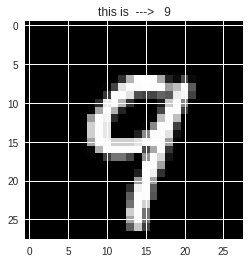

In [12]:
ind = 12

image = test_loader.dataset[ind][0].numpy().reshape(28,28)
lbl = test_loader.dataset[ind][1].numpy()
plt.title('this is  --->   ' + str(lbl))
plt.imshow(image, cmap='gray')


image_tensor, label_tensor = test_loader.dataset[ind]
image_tensor = image_tensor.reshape(1,1,28,28)
image_tensor, label_tensor = image_tensor.to(device), label_tensor.to(device)

prediction, features3d, features2d = model(image_tensor)
prediction = np.argmax(prediction.cpu().detach().numpy())
print ("\033[92m" + "PREDICTION : " + str(prediction) + "\033[0m")

print("features3d:  " + str(features3d.cpu().detach().numpy()))
print("features2d:  " + str(features2d.cpu().detach().numpy()))


-----------

In [0]:
# Visualize train_data

In [13]:
f3d = []
f2d = []
lbls = []
for i in range(10000):
    image_tensor, label_tensor = test_loader.dataset[i]
    image_tensor = image_tensor.reshape(1,1,28,28)
    image_tensor, label_tensor = image_tensor.to(device), label_tensor.to(device)

    prediction, features3d, features2d = model(image_tensor)
    f3d.append(features3d[0].cpu().detach().numpy())
    f2d.append(features2d[0].cpu().detach().numpy())
    
    prediction = np.argmax(prediction.cpu().detach().numpy())    
    lbls.append(prediction)

#     print("features3d:  " + str(features3d[0].detach().numpy()))
#     print("features2d:  " + str(features2d[0].detach().numpy()))

feat3d = np.array(f3d)
print("3d features shape" + str(feat3d.shape))

feat2d = np.array(f2d)
print("2d features shape" + str(feat2d.shape))

lbls = np.array(lbls)
print("labels shape" + str(lbls.shape))


3d features shape(10000, 3)
2d features shape(10000, 2)
labels shape(10000,)


# Visualize 2d

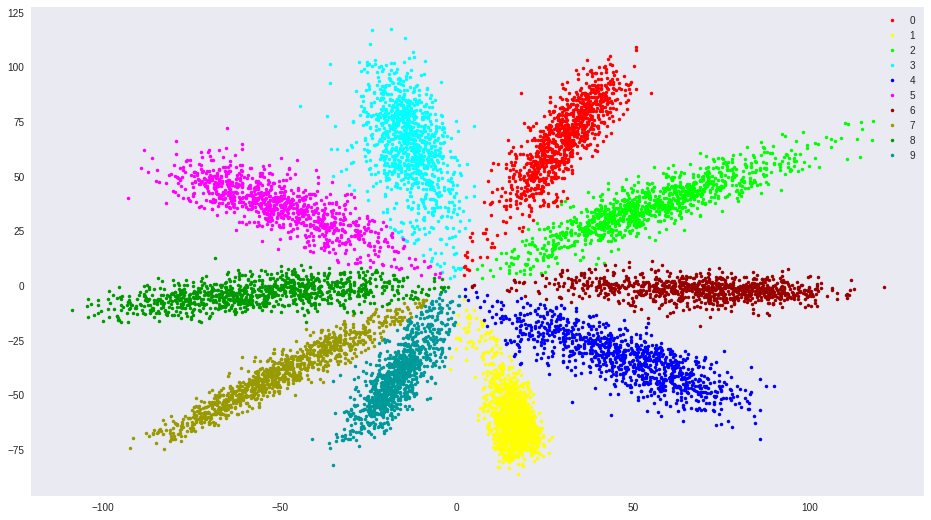

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

f = plt.figure(figsize=(16,9))
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', 
     '#ff00ff', '#990000', '#999900', '#009900', '#009999']
for i in range(10):
    plt.plot(feat2d[lbls==i,0].flatten(), feat2d[lbls==i,1].flatten(), '.', c=c[i])
plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

plt.grid()
plt.show()

# Visualize 3d

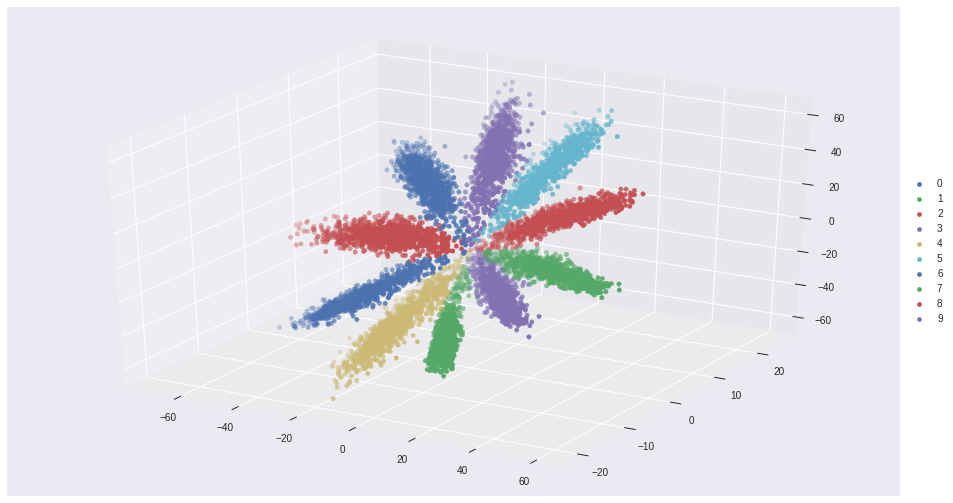

In [15]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection='3d')

for i in range(10):
    # Data for three-dimensional scattered points
    xdata = feat3d[lbls==i,2].flatten()
    ydata = feat3d[lbls==i,0].flatten()
    zdata = feat3d[lbls==i,1].flatten()
    ax.scatter3D(xdata, ydata, zdata);
ax.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()